# Segmentation of Indian Traffic

[Dataset Link](https://drive.google.com/drive/folders/1bynkOIXCurhJ9_Y5Q14KWX5yDyCRkKfN)

In [1]:
!pip install -Uq --root-user-action=ignore segmentation-models==1.0.1
!pip install -Uq --root-user-action=ignore opencv-python==4.6.0.66
!pip install -Uq --root-user-action=ignore imgaug==0.4.0
!pip install -Uq --root-user-action=ignore gdown

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import re
import cv2
import math
import json
import urllib
import pickle
import shutil

##############################################################
import gdown

id = '1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ'
gdown.download(id =id, quiet = True)
##############################################################

import numpy as np
from os import path
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from PIL import ImagePath
from PIL import Image, ImageDraw

plt.style.use('fivethirtyeight')

In [2]:
!unzip -q data.zip

# Directory to save processed files

if not os.path.isdir('results'):
    os.makedirs('results/unet')
    os.makedirs('results/canet')

In [3]:
!rm data.zip

def return_file_names_df(root_dir):
    
    images_l = []
    mask_l = []
    
    for folder in sorted(os.listdir(root_dir)):
        folder_dir = os.path.join(root_dir, folder)
        for in_folder in sorted(os.listdir(folder_dir)):
            files_dir = os.path.join(folder_dir, in_folder)
            for files in sorted(os.listdir(files_dir)):
                if folder == 'images':
                    images_l.append(os.path.join(files_dir, files))
                if folder == 'mask':
                    mask_l.append(os.path.join(files_dir, files))
                    
    data_df = pd.DataFrame({'image' : images_l, 'json' : mask_l})
    
    return data_df

root_dir = 'data'
data_df = return_file_names_df(root_dir)
data_df.head()

image  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  
0  data/mask/201/frame0029_gtFine_polygons.json  
1  data/mask/201/frame0299_gtFine_polygons.json  
2  data/mask/201/frame0779_gtFine_polygons.json  
3  data/mask/201/frame1019_gtFine_polygons.json  
4  data/mask/201/frame1469_gtFine_polygons.json

In [4]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and \
                    i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

grader_1(data_df)

True

In [5]:
def return_unique_labels(data_df):
    
    unique_labels = set()
    
    for row in tqdm(data_df['json']):
        with open(row) as f:
            json_r = json.load(f)
        for obj in json_r['objects']:
            unique_labels.add(obj['label'])
            
    return unique_labels

unique_labels = return_unique_labels(data_df)
print(f'Length of unique_labels :: {len(unique_labels)}')

100%|██████████████████████████████████████| 4008/4008 [00:19<00:00, 205.33it/s]

Length of unique_labels :: 40


In [6]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40, \
             'rail track':40, 'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, \
             'autorickshaw':80, 'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, \
             'caravan':90, 'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120, \
             'traffic sign':120, 'traffic light':120, 'pole':130, 'polegroup':130, \
             'obs-str-bar-fallback':130,'building':140, 'bridge':140,'tunnel':140, 'vegetation':150, \
             'sky':160, 'fallback background':160,'unlabeled':0, 'out of roi':0, 'ego vehicle':170, \
             'ground':180,'rectification border':190, 'train':200}

In [7]:
def grader_2(unique_labels):
    
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else: print("Flase")

grader_2(unique_labels)

True


In [8]:
def get_poly(file):
    
    label, vertexlist = [], []

    with open(file) as f:
        json_r = json.load(f)
        h = json_r['imgHeight']
        w = json_r['imgWidth']
        for obj in json_r['objects']:
                label.append(obj['label'])
                vertexlist.append([tuple(vertex) for vertex in obj['polygon']])
                
    return w, h, label, vertexlist

In [9]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and \
          isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


In [10]:
# https://stackoverflow.com/a/13819575

def compute_masks(data_df):
    
    mask_l = []
    
    mask_output_dir = 'data/output'
    if os.path.isdir(mask_output_dir):
        shutil.rmtree(mask_output_dir)
    os.mkdir(mask_output_dir)
    
    for row in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(row)
            
        img = Image.new('RGB', (w, h))
        img1 = ImageDraw.Draw(img)
        
        for idx, label in enumerate(labels):
            if len(vertexlist[idx]) > 1:
                img1.polygon(vertexlist[idx], fill = label_clr[labels[idx]])
        
        img = np.array(img)
        im = Image.fromarray(img[:, :, 0])
        
        new_name = re.sub(r'mask', 'output', row)
        new_name = re.sub(r'json', 'png', new_name)
        
        os.makedirs(mask_output_dir + '/' + new_name.split('/')[2], exist_ok = True)
        im.save(new_name)
        mask_l.append(new_name)
            
    data_df['mask'] = mask_l

    return data_df

data_df = compute_masks(data_df)
data_df.head()

100%|███████████████████████████████████████| 4008/4008 [02:54<00:00, 22.97it/s]


image  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  \
0  data/mask/201/frame0029_gtFine_polygons.json   
1  data/mask/201/frame0299_gtFine_polygons.json   
2  data/mask/201/frame0779_gtFine_polygons.json   
3  data/mask/201/frame1019_gtFine_polygons.json   
4  data/mask/201/frame1469_gtFine_polygons.json   

                                            mask  
0  data/output/201/frame0029_gtFine_polygons.png  
1  data/output/201/frame0299_gtFine_polygons.png  
2  data/output/201/frame0779_gtFine_polygons.png  
3  data/output/201/frame1019_gtFine_polygons.png  
4  data/output/201/frame1469_gtFine_polygons.png

In [11]:
# saving the final dataframe to a csv file

if not os.path.isdir('results'):
    os.mkdir('results')
    
data_df.to_csv('results/preprocessed_data.csv', index = False)
print("Preprocessed Data saved sucessfully at 'results/preprocessed_data.csv' directory")

Preprocessed Data saved sucessfully at 'results/preprocessed_data.csv' directory


In [12]:
with open('results/label_clr.pkl', 'wb') as f:
    pickle.dump(label_clr, f, protocol=pickle.HIGHEST_PROTOCOL)

# <font color = 'red'>Acceptance Threshold</font>

<img src = 'https://i.imgur.com/dzfkzbK.png'>

# Task 3: Training CANet

In [13]:
# https://github.com/qubvel/segmentation_models

!pip install -Uq --root-user-action=ignore segmentation-models==1.0.1
!pip install -Uq --root-user-action=ignore opencv-python==4.6.0.66
!pip install -Uq --root-user-action=ignore imgaug==0.4.0

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import re
import cv2
import math
import json
import glob
import random
import urllib
import shutil
import pickle

import numpy as np
from os import path
import pandas as pd
from tqdm import tqdm

from PIL import ImagePath
from PIL import Image, ImageDraw

from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform

import imgaug.augmenters as iaa
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score # Intersection over Union

K.set_learning_phase(1)
K.set_image_data_format('channels_last')
plt.style.use('fivethirtyeight')

tf.keras.backend.set_image_data_format('channels_last')
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


/opt/conda/lib/python3.7/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">

* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [14]:
'''
WARNING:tensorflow:Model failed to serialize as JSON. Ignoring... 
Layer convolutional_block has arguments ['self', 'kernel', 'filters', 'stride']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
        
SOLUTION :: https://stackoverflow.com/a/62838569
'''

class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel = 3,  filters = [4, 4, 8], stride = 1, name = "convblock"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv1 = Conv2D(filters = self.F1, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        self.conv2 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), \
                            strides = (self.stride, self.stride), padding = 'same')
        self.conv3 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        self.conv4 = Conv2D(filters = self.F3, kernel_size = (self.kernel, self.kernel), \
                            strides = (self.stride, self.stride), padding = 'same')
        
        self.batchnorm1 = BatchNormalization(axis = 3)
        self.batchnorm2 = BatchNormalization(axis = 3)
        self.batchnorm3 = BatchNormalization(axis = 3)
        self.batchnorm4 = BatchNormalization(axis = 3)
        
        self.activ = Activation('relu')
        self.add = Add()
        
    def get_config(self):
        cfg = super().get_config()
        return cfg
    
    def call(self, X):
        # write the architecutre that was mentioned above
        
        input_ = X
        # Block 1
        conv1 = self.conv1(X)
        batch1 = self.batchnorm1(conv1)
        activ1 = self.activ(batch1)
        # Block 2
        conv2 = self.conv2(activ1)
        batch2 = self.batchnorm2(conv2)
        activ2 = self.activ(batch2)
        # # Block 3
        conv3 = self.conv3(activ2)
        batch3 = self.batchnorm3(conv3)
        
        # SkipConnection
        input_ = self.conv4(input_)
        input_ = self.batchnorm4(input_)
        input_ = self.activ(input_)
        
        X = self.add((batch3, input_))
        X = self.activ(X)
        
        return X

In [15]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel = 3,  filters = [4, 4, 8], name = 'identity_block'):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        
        self.conv1 = Conv2D(filters = self.F1, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        self.conv2 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), \
                            strides = (1, 1), padding = 'same')
        self.conv3 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        
        self.batchnorm1 = BatchNormalization(axis = 3)
        self.batchnorm2 = BatchNormalization(axis = 3)
        self.batchnorm3 = BatchNormalization(axis = 3)
        
        self.activ = Activation('relu')
        self.add = Add()
        # print('filters ::', self.F1, self.F2, self.F3)
        
    def get_config(self):
        cfg = super().get_config()
        return cfg  
    
    def call(self, X):
        # write the architecutre that was mentioned above
        
        input_ = X
        # Block 1
        conv1 = self.conv1(X)
        batch1 = self.batchnorm1(conv1)
        activ1 = self.activ(batch1)
        # Block 2
        conv2 = self.conv2(activ1)
        batch2 = self.batchnorm2(conv2)
        activ2 = self.activ(batch2)
        # # Block 3
        conv3 = self.conv3(activ2)
        batch3 = self.batchnorm3(conv3)
        
        # SkipConnection
        X = self.add([batch3, input_])
        X = self.activ(X)
        
        return X

In [16]:
X_input = Input(shape = (512, 512, 3))
print(f'\33[31mInput Image Size\033[0m : {X_input.shape}')

def convolutional_identity_block(x_input):
    
    # Stage 1
    X = Conv2D(64, (3, 3), name = 'conv1', padding = "same", \
                   kernel_initializer = glorot_uniform(seed = 0))(x_input)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides = (2, 2))(X)

    # First Convolutional Block
    C1 = convolutional_block(kernel = 3, filters = [4, 4, 8], stride = 2, name = 'convblock1')(X)
    C1 = identity_block(kernel = 3, filters = [4, 4, 8], name = 'identity_block1')(C1)
    print(f'C1 Shape : {C1.shape}')

    # Second Convolutional Block
    C2 = convolutional_block(kernel = 3, filters = [8, 8, 16], stride = 2, name = 'convblock2')(C1)
    C2 = identity_block(kernel = 3, filters = [8, 8, 16], name = 'identity_block2a')(C2)
    C2 = identity_block(kernel = 3, filters = [8, 8, 16], name = 'identity_block2b')(C2)
    print(f'C2 Shape : {C2.shape}')

    # Third Convolutional Block
    C3 = convolutional_block(kernel = 3, filters = [16, 16, 32], stride = 1, name = 'convblock3')(C2)
    C3 = identity_block(kernel = 3, filters = [16, 16, 32], name = 'identity_block3a')(C3)
    C3 = identity_block(kernel = 3, filters = [16, 16, 32], name = 'identity_block3b')(C3)
    C3 = identity_block(kernel = 3, filters = [16, 16, 32], name = 'identity_block3c')(C3)
    print(f'C3 Shape : {C3.shape}')

    # Fourth Convolutional Block
    C4 = convolutional_block(kernel = 3,filters = [32, 32, 64], stride = 1, name = 'convblock4')(C3)
    C4 = identity_block(kernel = 3, filters = [32, 32, 64], name = 'identity_block4a')(C4)
    C4 = identity_block(kernel = 3, filters = [32, 32, 64], name = 'identity_block4b')(C4)
    C4 = identity_block(kernel = 3, filters = [32, 32, 64], name = 'identity_block4c')(C4)
    C4 = identity_block(kernel = 3, filters = [32, 32, 64], name = 'identity_block4d')(C4)
    print(f'C4 Shape : {C4.shape}')
    return C1, C2, C3, C4
    
C1, C2, C3, C4 = convolutional_identity_block(X_input)

Input Image Size : (None, 512, 512, 3)
C1 Shape : (None, 128, 128, 8)
C2 Shape : (None, 64, 64, 16)
C3 Shape : (None, 64, 64, 32)
C4 Shape : (None, 64, 64, 64)


<font color = 'red'>Example:</font>
* If your image is of size (512, 512, 3)
    * The output after $C_1$ will be $128*128*8$
    * The output after $C_2$ will be $64*64*16$
    * The output after $C_3$ will be $64*64*32$
    * The output after $C_4$ will be $64*64*64$

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [17]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, name="global_flow"):
        super().__init__(name=name)
        
        self.golbalavg = GlobalAveragePooling2D()
        self.batchnorm1 = BatchNormalization(axis = 3)
        self.activ = Activation('relu')
        self.conv = Conv2D(filters = 32, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        self.upsample = UpSampling2D(size = (input_dim, output_dim), interpolation = 'bilinear')
        
    def get_config(self):
        cfg = super().get_config()
        return cfg  
    
    def call(self, X):
        # implement the global flow operatiom
        
        X = self.golbalavg(X) # Outputs : (None, chanel)
        X = tf.expand_dims(X, 1) # Outputs : (None, 1, chanel)
        X = tf.expand_dims(X, 1) # Outputs : ((None, 1, 1, chanel)
        X = self.batchnorm1(X)
        X = self.activ(X)
        X = self.conv(X)
        X = self.upsample(X)
        
        return X

In [18]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name = "context_flow"):
        super().__init__(name=name)
        
        self.activR = Activation('relu')
        self.activS = Activation('sigmoid')
        self.avgpool = AveragePooling2D(pool_size = (2, 2))
        self.conv1 = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')
        self.conv2 = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')
        self.conv3 = Conv2D(filters = 32, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        self.conv4 = Conv2D(filters = 32, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        self.upsample = UpSampling2D(size = (2, 2), interpolation = 'bilinear')
        
        self.add = Add()
        self.multiply = Multiply()
        self.concat = Concatenate()
        
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        # implement the context flow as mentioned in the above cell
        # Fusion Module
        fusion_m = self.concat([INP, FLOW])
        fusion_m = self.avgpool(fusion_m)
        fusion_m = self.conv1(fusion_m)
        fusion_m = self.conv2(fusion_m)
        
        # Refinement Module
        refine_m = self.conv3(fusion_m)
        refine_m = self.activR(refine_m)
        refine_m = self.conv4(refine_m)
        refine_m = self.activS(refine_m)
        
        # Multiplying, adding and upsampling
        multiplied = self.multiply([fusion_m, refine_m])
        added = self.add([fusion_m, multiplied])
        X = self.upsample(added)
        
        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.

In [19]:
X_input = Input(shape = (512, 512, 3))

def global_context_sum(x_input):
    
    C1, C2, C3, C4 = convolutional_identity_block(x_input)
    
    input_dim = C4.shape[1]
    output_dim = C4.shape[2]
    channels = C4.shape[-1]

    global_f = global_flow(input_dim, output_dim)(C4)
    print(f'\nGlobal Flow Shape : {global_f.shape}')

    cont_flow_in = [C4, global_f]
    context_f1 = context_flow(name = 'context_flow1')([C4, global_f])
    print(f'\nContext Flow 1 Shape : {context_f1.shape}')

    context_f2 = context_flow(name = 'context_flow2')([C4, context_f1])
    print(f'Context Flow 2 Shape : {context_f1.shape}')

    context_f3 = context_flow(name = 'context_flow3')([C4, context_f2])
    print(f'Context Flow 3 Shape : {context_f1.shape}')


    global_context_sum = Add()([global_f, context_f1, context_f2, context_f3])
    print(f'\nGlobal+Context Shape : {global_context_sum.shape}')
    
    return C1, C2, C3, C4, global_context_sum
    
C1, C2, C3, C4, glob_cont_sum = global_context_sum(X_input)

C1 Shape : (None, 128, 128, 8)
C2 Shape : (None, 64, 64, 16)
C3 Shape : (None, 64, 64, 32)
C4 Shape : (None, 64, 64, 64)

Global Flow Shape : (None, 64, 64, 32)

Context Flow 1 Shape : (None, 64, 64, 32)
Context Flow 2 Shape : (None, 64, 64, 32)
Context Flow 3 Shape : (None, 64, 64, 32)

Global+Context Shape : (None, 64, 64, 32)


<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [20]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        
        self.multiply = Multiply()
        self.activ = Activation('sigmoid')
        self.golbalavg = GlobalAveragePooling2D()
        self.batchnorm = BatchNormalization(axis = 3)
        self.upsample = UpSampling2D(size = (2, 2), interpolation = 'bilinear')
        self.conv1 = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')
        self.conv2 = Conv2D(filters = 32, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        
        conv3 = self.conv1(X)
        X = self.golbalavg(conv3)
        X = tf.expand_dims(X, 1)
        X = tf.expand_dims(X, 1)
        X = self.conv2(X)
        X = self.batchnorm(X)
        X = self.activ(X)
        multiplied = self.multiply([conv3, X])
        FSM_Conv_T = self.upsample(multiplied)
        
        return FSM_Conv_T

In [21]:
def FSM_Conv_T(x_input):
    
    C1, C2, C3, C4, glob_cont_sum = global_context_sum(x_input)

    featue_sel = fsm()(glob_cont_sum)
    print(f'\nFeature Selection Module : {featue_sel.shape}')
    
    return C1, C2, C3, C4, glob_cont_sum, featue_sel

C1, C2, C3, C4, glob_cont_sum, featue_sel = FSM_Conv_T(X_input)

C1 Shape : (None, 128, 128, 8)
C2 Shape : (None, 64, 64, 16)
C3 Shape : (None, 64, 64, 32)
C4 Shape : (None, 64, 64, 64)

Global Flow Shape : (None, 64, 64, 32)

Context Flow 1 Shape : (None, 64, 64, 32)
Context Flow 2 Shape : (None, 64, 64, 32)
Context Flow 3 Shape : (None, 64, 64, 32)

Global+Context Shape : (None, 64, 64, 32)

Feature Selection Module : (None, 128, 128, 32)


<font color="red">Example</font>
* Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [22]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name = "global_conv_net"):
        super().__init__(name = name)
        
        self.add = Add()
        self.conv1 = Conv2D(filters = 32, kernel_size = (7, 1), strides = (1, 1), padding = 'same')
        self.conv2 = Conv2D(filters = 32, kernel_size = (1, 7), strides = (1, 1), padding = 'same')
        self.conv3 = Conv2D(filters = 32, kernel_size = (1, 7), strides = (1, 1), padding = 'same')
        self.conv4 = Conv2D(filters = 32, kernel_size = (7, 1), strides = (1, 1), padding = 'same')
        self.conv5 = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')
        
    def call(self, X):
        # please implement the above mentioned architecture
        
        # Left Conv
        left = self.conv1(X)
        left = self.conv2(left)
        
        # Right Conv
        right = self.conv3(X)
        right = self.conv4(right)
        
        # Adding and skipping
        l_r = self.add([left, right])
        con3 = self.conv5(l_r)
        X = self.add([con3, l_r])
        
        return X

In [23]:
def adaptGlobalConv(x_input):
    
    C1, C2, C3, C4, glob_cont_sum, featue_sel = FSM_Conv_T(x_input)
    
    adpted_glob_conv = agcn()(C1)

    print(f'\nAdapted Global Conv. Network : {adpted_glob_conv.shape}')
    
    return C1, C2, C3, C4, glob_cont_sum, featue_sel, adpted_glob_conv

C1, C2, C3, C4, glob_cont_sum, featue_sel, adpted_glob_conv = adaptGlobalConv(X_input)

C1 Shape : (None, 128, 128, 8)
C2 Shape : (None, 64, 64, 16)
C3 Shape : (None, 64, 64, 32)
C4 Shape : (None, 64, 64, 64)

Global Flow Shape : (None, 64, 64, 32)

Context Flow 1 Shape : (None, 64, 64, 32)
Context Flow 2 Shape : (None, 64, 64, 32)
Context Flow 3 Shape : (None, 64, 64, 32)

Global+Context Shape : (None, 64, 64, 32)

Feature Selection Module : (None, 128, 128, 32)

Adapted Global Conv. Network : (None, 128, 128, 32)


<font color="red">Example</font>:
* Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

<img src='https://i.imgur.com/prH3Mno.png' width="600">


* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [24]:
def generate_final_out(x_input):
    
    C1, C2, C3, C4, glob_cont_sum, featue_sel, adpted_glob_conv = adaptGlobalConv(x_input)

    concat_AGCN_FSM = Concatenate()([featue_sel, adpted_glob_conv])
    print(f'\nAGCN_FSM Concat Shape: {concat_AGCN_FSM.shape}')

    conv_layer = Conv2D(filters = 21, kernel_size = (1, 1), strides = (1, 1), \
                                                                padding = 'same')(concat_AGCN_FSM)
    print(f'\nConvolution Layer Shape: {conv_layer.shape}')

    upsampled = UpSampling2D(size = (4, 4), interpolation = 'bilinear')(conv_layer) # 128*4 = 512
    print(f'\nUpsampled Layer Shape: {upsampled.shape}')
    
    final_out = Activation('sigmoid')(upsampled)
    
    print(f'\nFinal Shape post sigmoid activation: {final_out.shape}')
    
    return final_out

output = generate_final_out(X_input)

C1 Shape : (None, 128, 128, 8)
C2 Shape : (None, 64, 64, 16)
C3 Shape : (None, 64, 64, 32)
C4 Shape : (None, 64, 64, 64)

Global Flow Shape : (None, 64, 64, 32)

Context Flow 1 Shape : (None, 64, 64, 32)
Context Flow 2 Shape : (None, 64, 64, 32)
Context Flow 3 Shape : (None, 64, 64, 32)

Global+Context Shape : (None, 64, 64, 32)

Feature Selection Module : (None, 128, 128, 32)

Adapted Global Conv. Network : (None, 128, 128, 32)

AGCN_FSM Concat Shape: (None, 128, 128, 64)

Convolution Layer Shape: (None, 128, 128, 21)

Upsampled Layer Shape: (None, 512, 512, 21)

Final Shape post sigmoid activation: (None, 512, 512, 21)


<font color = 'red'>Example:</font>
* Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
* Applying conv layer will make it (128,128,21)
* Finally applying upsampling will make it (512, 512, 21)
* Applying sigmoid will result in the same matrix (512, 512, 21)

In [25]:
# Constatnts

EPOCH = 20
IMG_SIZE = 128
BATCH_SIZE = 64
NUM_CLASSES = 21

In [26]:
tf.keras.backend.clear_session()
X_input = Input(shape = (IMG_SIZE, IMG_SIZE, 3))
output = generate_final_out(X_input)

C1 Shape : (None, 32, 32, 8)
C2 Shape : (None, 16, 16, 16)
C3 Shape : (None, 16, 16, 32)
C4 Shape : (None, 16, 16, 64)

Global Flow Shape : (None, 16, 16, 32)

Context Flow 1 Shape : (None, 16, 16, 32)
Context Flow 2 Shape : (None, 16, 16, 32)
Context Flow 3 Shape : (None, 16, 16, 32)

Global+Context Shape : (None, 16, 16, 32)

Feature Selection Module : (None, 32, 32, 32)

Adapted Global Conv. Network : (None, 32, 32, 32)

AGCN_FSM Concat Shape: (None, 32, 32, 64)

Convolution Layer Shape: (None, 32, 32, 21)

Upsampled Layer Shape: (None, 128, 128, 21)

Final Shape post sigmoid activation: (None, 128, 128, 21)


* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [27]:
# write the complete architecutre

model_canet = Model(inputs = X_input, outputs = output)

model_canet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 128, 128, 64  256         ['conv1[0][0]']                  
                                )                                                             

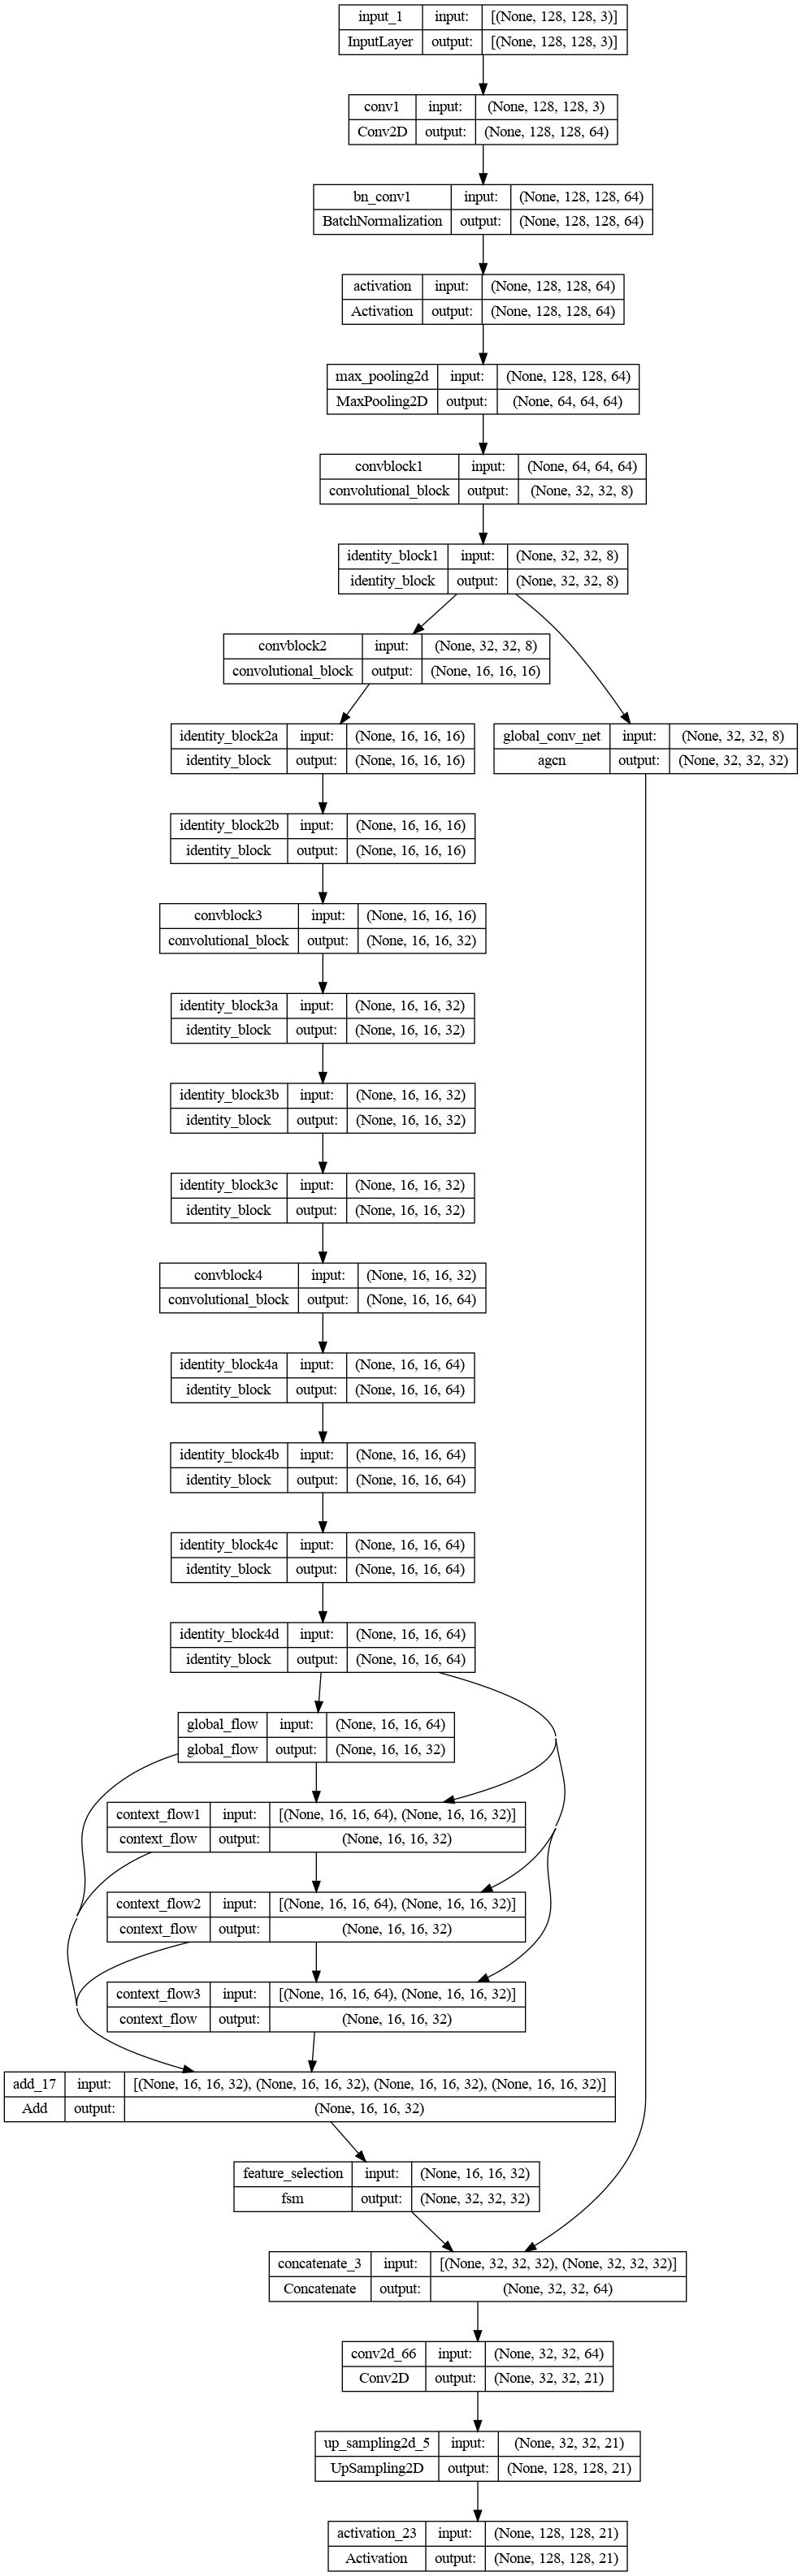

In [28]:
plot_model(model_canet, to_file = 'results/model_CANet.png', show_shapes = True, \
                                                       show_layer_names = True, rankdir = 'TB')

In [29]:
# Image augumentation techniques

aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [30]:
def visualize(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

class Dataset:

    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    
    def __init__(self,basepath, img_files, mask_files, CLASSES, img_size):
        
        self.img_ids = img_files
        self.mask_ids = mask_files
        self.img_size = img_size
        
        # the paths of images
        self.images_fps = [os.path.join(basepath, image_id) for image_id in self.img_ids]
        
        # the paths of segmentation images
        self.masks_fps = [os.path.join(basepath, mask_id) for mask_id in self.mask_ids]
        
        # giving labels for each class
        self.class_values = CLASSES
        self.CLASSES = CLASSES
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(self.img_size, self.img_size), interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask  = cv2.resize(mask,(self.img_size, self.img_size), interpolation = cv2.INTER_AREA)
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        
        if self.images_fps[i] in X_train:
            
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = aug5.augment_image(image_mask)
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)

        return image, image_mask
        
    def __len__(self):
        return len(self.img_ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size = 1, shuffle = False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [31]:
data_df = pd.read_csv('results/preprocessed_data.csv')
data_df.head()

image  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  \
0  data/mask/201/frame0029_gtFine_polygons.json   
1  data/mask/201/frame0299_gtFine_polygons.json   
2  data/mask/201/frame0779_gtFine_polygons.json   
3  data/mask/201/frame1019_gtFine_polygons.json   
4  data/mask/201/frame1469_gtFine_polygons.json   

                                            mask  
0  data/output/201/frame0029_gtFine_polygons.png  
1  data/output/201/frame0299_gtFine_polygons.png  
2  data/output/201/frame0779_gtFine_polygons.png  
3  data/output/201/frame1019_gtFine_polygons.png  
4  data/output/201/frame1469_gtFine_polygons.png

In [32]:
with open('results/label_clr.pkl', 'rb') as f:
    label_clr = pickle.load(f)
    
print(f'Length of label_clr :: {len(label_clr)}')

Length of label_clr :: 40


In [33]:
X_train, X_test = train_test_split(data_df, test_size = 0.1, random_state = 42)

In [34]:
CLASSES = list(np.unique(list(label_clr.values())))

basepath = './'

train_dataset = Dataset(basepath, X_train['image'].values, X_train['mask'].values, \
                        CLASSES, img_size = IMG_SIZE)

test_dataset  = Dataset(basepath, X_test['image'].values, X_test['mask'].values, \
                        CLASSES, img_size = IMG_SIZE)


train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = Dataloder(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

train_steps = X_train.shape[0]//BATCH_SIZE
valid_steps = X_test.shape[0]//BATCH_SIZE

In [35]:
def assert_check(tr_dataloader, batch_size, img_size, num_classes):

    print(f'train_dataloader[0][0].shape : {tr_dataloader[0][0].shape}')
    print(f'train_dataloader[0][1].shape : {tr_dataloader[0][1].shape}')

    assert tr_dataloader[0][0].shape == (batch_size, img_size, img_size, 3)
    assert tr_dataloader[0][1].shape == (batch_size, img_size, img_size, num_classes)
    
    return True

assert_check(train_dataloader, BATCH_SIZE, IMG_SIZE, NUM_CLASSES)

train_dataloader[0][0].shape : (64, 128, 128, 3)
train_dataloader[0][1].shape : (64, 128, 128, 21)


True

In [36]:
# https://stackoverflow.com/a/59564740

class AccThreshold(Callback):

    def __init__(self, thres_val):
        self.thres_val = thres_val
        
    def on_epoch_end(self, epoch, logs = {}):
        
        val_iou = logs.get('val_iou_score') 
        if val_iou >= self.thres_val:
            print(f'\n\n\tTerminating training at epoch {epoch+1} with a minimum IntersectionOverUnion accuracy of {self.thres_val} %\n')
            self.model.stop_training = True

In [37]:
def save_models(model, res_model, model_name):
    
    model.save(f'results/{model_name}.h5')
    model.save_weights(f'results/wt_{model_name}.h5')
    with open(f'results/{model_name}.txt', 'w') as file:
        file.write(str(res_model.history))

In [38]:
# Callbacks

cust_callback = AccThreshold(thres_val = 0.4)

filepath = 'results/canet/EPO_{epoch:02d}-IOU_{val_iou_score:.3f}.h5'
model_point = ModelCheckpoint(filepath, save_weights_only = True, save_best_only = True, \
                              mode = 'min', monitor = 'val_iou_score')

logdir = 'results/logs/canet/' + datetime.now().strftime('%d_%h%y_%H_%M_%S')
tensorBoard = TensorBoard(log_dir = logdir, histogram_freq = 0, write_graph = True)

callBacks = [model_point, tensorBoard, cust_callback]

In [39]:
focal_loss = sm.losses.cce_dice_loss
optimizer_ = tf.keras.optimizers.Adam(1e-4)

model_canet.compile(optimizer_, focal_loss, metrics = [iou_score])

In [40]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [41]:
# Model Training

with tf.device('/device:GPU:0'):
    
    model_res_canet = model_canet.fit(train_dataloader, steps_per_epoch = train_steps, \
                  epochs = EPOCH, validation_data = test_dataloader, validation_steps = valid_steps, \
                  callbacks = callBacks)

    save_models(model_canet, model_res_canet, 'model_canet')

Epoch 1/20
56/56 [==============================] - 213s 4s/step - loss: 0.9930 - iou_score: 0.0677 - val_loss: 1.0166 - val_iou_score: 0.0548
Epoch 2/20
56/56 [==============================] - 214s 4s/step - loss: 0.9189 - iou_score: 0.1025 - val_loss: 1.0099 - val_iou_score: 0.0618
Epoch 3/20
56/56 [==============================] - 215s 4s/step - loss: 0.8862 - iou_score: 0.1210 - val_loss: 0.9984 - val_iou_score: 0.0707
Epoch 4/20
56/56 [==============================] - 213s 4s/step - loss: 0.8649 - iou_score: 0.1342 - val_loss: 0.9454 - val_iou_score: 0.0927
Epoch 5/20
56/56 [==============================] - 210s 4s/step - loss: 0.8535 - iou_score: 0.1416 - val_loss: 0.9165 - val_iou_score: 0.1133
Epoch 6/20
56/56 [==============================] - 220s 4s/step - loss: 0.8435 - iou_score: 0.1479 - val_loss: 0.8847 - val_iou_score: 0.1257
Epoch 7/20
56/56 [==============================] - 221s 4s/step - loss: 0.8372 - iou_score: 0.1519 - val_loss: 0.8624 - val_iou_score: 0.1373

In [42]:
with tf.device('/device:GPU:0'):
    
    model_res_canet2 = model_canet.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 40, \
                                       initial_epoch = 20, validation_data = test_dataloader, \
                                       validation_steps = valid_steps, callbacks = callBacks)

    save_models(model_canet, model_res_canet2, 'model_canet2')

Epoch 21/40
56/56 [==============================] - 218s 4s/step - loss: 0.7719 - iou_score: 0.1951 - val_loss: 0.8030 - val_iou_score: 0.1783
Epoch 22/40
56/56 [==============================] - 204s 4s/step - loss: 0.7687 - iou_score: 0.1970 - val_loss: 0.8131 - val_iou_score: 0.1730
Epoch 23/40
56/56 [==============================] - 215s 4s/step - loss: 0.7661 - iou_score: 0.1988 - val_loss: 0.8033 - val_iou_score: 0.1786
Epoch 24/40
56/56 [==============================] - 215s 4s/step - loss: 0.7627 - iou_score: 0.2013 - val_loss: 0.8080 - val_iou_score: 0.1781
Epoch 25/40
56/56 [==============================] - 202s 4s/step - loss: 0.7581 - iou_score: 0.2044 - val_loss: 0.7863 - val_iou_score: 0.1881
Epoch 26/40
56/56 [==============================] - 196s 3s/step - loss: 0.7570 - iou_score: 0.2051 - val_loss: 0.8216 - val_iou_score: 0.1712
Epoch 27/40
56/56 [==============================] - 197s 4s/step - loss: 0.7549 - iou_score: 0.2069 - val_loss: 0.8156 - val_iou_score:

In [43]:
with tf.device('/device:GPU:0'):
    
    model_res_canet3 = model_canet.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 60, \
                                       initial_epoch = 40, validation_data = test_dataloader, \
                                       validation_steps = valid_steps, callbacks = callBacks)

    save_models(model_canet, model_res_canet3, 'model_canet3')

Epoch 41/60
56/56 [==============================] - 211s 4s/step - loss: 0.7254 - iou_score: 0.2277 - val_loss: 0.7963 - val_iou_score: 0.1843
Epoch 42/60
56/56 [==============================] - 199s 4s/step - loss: 0.7228 - iou_score: 0.2292 - val_loss: 0.7946 - val_iou_score: 0.1879
Epoch 43/60
56/56 [==============================] - 194s 3s/step - loss: 0.7187 - iou_score: 0.2325 - val_loss: 0.7903 - val_iou_score: 0.1905
Epoch 44/60
56/56 [==============================] - 197s 4s/step - loss: 0.7191 - iou_score: 0.2323 - val_loss: 0.7766 - val_iou_score: 0.1958
Epoch 45/60
56/56 [==============================] - 193s 3s/step - loss: 0.7186 - iou_score: 0.2326 - val_loss: 0.8233 - val_iou_score: 0.1768
Epoch 46/60
56/56 [==============================] - 193s 3s/step - loss: 0.7135 - iou_score: 0.2362 - val_loss: 0.7861 - val_iou_score: 0.1915
Epoch 47/60
56/56 [==============================] - 194s 3s/step - loss: 0.7092 - iou_score: 0.2395 - val_loss: 0.7891 - val_iou_score:

In [44]:
with tf.device('/device:GPU:0'):
    
    model_res_canet4 = model_canet.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 80, \
                                       initial_epoch = 60, validation_data = test_dataloader, \
                                       validation_steps = valid_steps, callbacks = callBacks)

    save_models(model_canet, model_res_canet4, 'model_canet4')

Epoch 61/80
56/56 [==============================] - 200s 4s/step - loss: 0.5083 - iou_score: 0.4371 - val_loss: 0.6060 - val_iou_score: 0.3811
Epoch 62/80
56/56 [==============================] - 196s 3s/step - loss: 0.5066 - iou_score: 0.4378 - val_loss: 0.6035 - val_iou_score: 0.3818
Epoch 63/80
56/56 [==============================] - 190s 3s/step - loss: 0.5016 - iou_score: 0.4414 - val_loss: 0.6029 - val_iou_score: 0.3825
Epoch 64/80
56/56 [==============================] - 193s 3s/step - loss: 0.5090 - iou_score: 0.4361 - val_loss: 0.6065 - val_iou_score: 0.3779
Epoch 65/80
56/56 [==============================] - 192s 3s/step - loss: 0.5049 - iou_score: 0.4389 - val_loss: 0.6066 - val_iou_score: 0.3804
Epoch 66/80
56/56 [==============================] - 194s 3s/step - loss: 0.4988 - iou_score: 0.4434 - val_loss: 0.5950 - val_iou_score: 0.3876
Epoch 67/80
56/56 [==============================] - 189s 3s/step - loss: 0.4963 - iou_score: 0.4450 - val_loss: 0.6033 - val_iou_score:

In [45]:
with tf.device('/device:GPU:0'):
    
    model_res_canet5 = model_canet.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 100, \
                                       initial_epoch = 80, validation_data = test_dataloader, \
                                       validation_steps = valid_steps, callbacks = callBacks)

    save_models(model_canet, model_res_canet5, 'model_canet5')

Epoch 81/100
56/56 [==============================] - 198s 4s/step - loss: 0.4832 - iou_score: 0.4549 - val_loss: 0.5979 - val_iou_score: 0.3850
Epoch 82/100
56/56 [==============================] - 196s 3s/step - loss: 0.4800 - iou_score: 0.4572 - val_loss: 0.5978 - val_iou_score: 0.3859
Epoch 83/100
56/56 [==============================] - 195s 3s/step - loss: 0.4771 - iou_score: 0.4597 - val_loss: 0.6055 - val_iou_score: 0.3829
Epoch 84/100
56/56 [==============================] - 195s 3s/step - loss: 0.4748 - iou_score: 0.4615 - val_loss: 0.5981 - val_iou_score: 0.3868
Epoch 85/100
56/56 [==============================] - 195s 3s/step - loss: 0.4729 - iou_score: 0.4631 - val_loss: 0.6090 - val_iou_score: 0.3808
Epoch 86/100
56/56 [==============================] - 196s 3s/step - loss: 0.4722 - iou_score: 0.4633 - val_loss: 0.6043 - val_iou_score: 0.3828
Epoch 87/100
56/56 [==============================] - 183s 3s/step - loss: 0.4751 - iou_score: 0.4612 - val_loss: 0.6056 - val_iou

In [46]:
!ls results/

canet		  model_canet3.txt  model_CANet.png	   wt_model_canet4.h5
label_clr.pkl	  model_canet4.h5   model_canet.txt	   wt_model_canet5.h5
logs		  model_canet4.txt  preprocessed_data.csv  wt_model_canet.h5
model_canet2.h5   model_canet5.h5   unet
model_canet2.txt  model_canet5.txt  wt_model_canet2.h5
model_canet3.h5   model_canet.h5    wt_model_canet3.h5


In [47]:
!zip -r CANet_100Epo_loss_4589_iou_4741_vloss_6009_viou_3854.zip results/

  adding: results/ (stored 0%)
  adding: results/model_canet4.txt (deflated 53%)
  adding: results/label_clr.pkl (deflated 35%)
  adding: results/model_canet2.h5 (deflated 26%)
  adding: results/model_canet5.txt (deflated 54%)
  adding: results/preprocessed_data.csv (deflated 93%)
  adding: results/wt_model_canet2.h5 (deflated 25%)
  adding: results/model_canet5.h5 (deflated 26%)
  adding: results/unet/ (stored 0%)
  adding: results/wt_model_canet.h5 (deflated 25%)
  adding: results/model_canet3.txt (deflated 52%)
  adding: results/model_canet2.txt (deflated 53%)
  adding: results/wt_model_canet3.h5 (deflated 25%)
  adding: results/wt_model_canet5.h5 (deflated 25%)
  adding: results/canet/ (stored 0%)
  adding: results/canet/EPO_01-IOU_0.055.h5 (deflated 26%)
  adding: results/model_canet3.h5 (deflated 26%)
  adding: results/model_canet.txt (deflated 52%)
  adding: results/model_CANet.png (deflated 17%)
  adding: results/model_canet.h5 (deflated 26%)
  adding: results/logs/ (stored 0%)

In [48]:
with tf.device('/device:GPU:0'):
    
    model_res_canet6 = model_canet.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 110, \
                                       initial_epoch = 100, validation_data = test_dataloader, \
                                       validation_steps = valid_steps, callbacks = callBacks)

    save_models(model_canet, model_res_canet6, 'model_canet6')

Epoch 101/110
56/56 [==============================] - ETA: 0s - loss: 0.4604 - iou_score: 0.4729

	Terminating training at epoch 101 with a minimum IntersectionOverUnion accuracy of 0.4 %

56/56 [==============================] - 193s 3s/step - loss: 0.4604 - iou_score: 0.4729 - val_loss: 0.5084 - val_iou_score: 0.4414


In [49]:
# Combining all the history files to plot graph

import ast

with open('results/model_canet.txt', 'r') as file:
    mod_0_20 = ast.literal_eval(file.read())
with open('results/model_canet2.txt', 'r') as file:
    mod_20_40 = ast.literal_eval(file.read())
with open('results/model_canet3.txt', 'r') as file:
    mod_40_60 = ast.literal_eval(file.read())
with open('results/model_canet4.txt', 'r') as file:
    mod_60_80 = ast.literal_eval(file.read())
with open('results/model_canet5.txt', 'r') as file:
    mod_80_100 = ast.literal_eval(file.read())
with open('results/model_canet6.txt', 'r') as file:
    mod_100_110 = ast.literal_eval(file.read())

combined = {}

for key in mod_0_20:
    if not key in combined.keys():
        combined[key] = []
    combined[key].extend(mod_0_20[key])
    combined[key].extend(mod_20_40[key])
    combined[key].extend(mod_40_60[key])
    combined[key].extend(mod_60_80[key])
    combined[key].extend(mod_80_100[key])
    combined[key].extend(mod_100_110[key])
    
with open('results/combined_canet.txt', 'w') as file:
        file.write(str(combined))

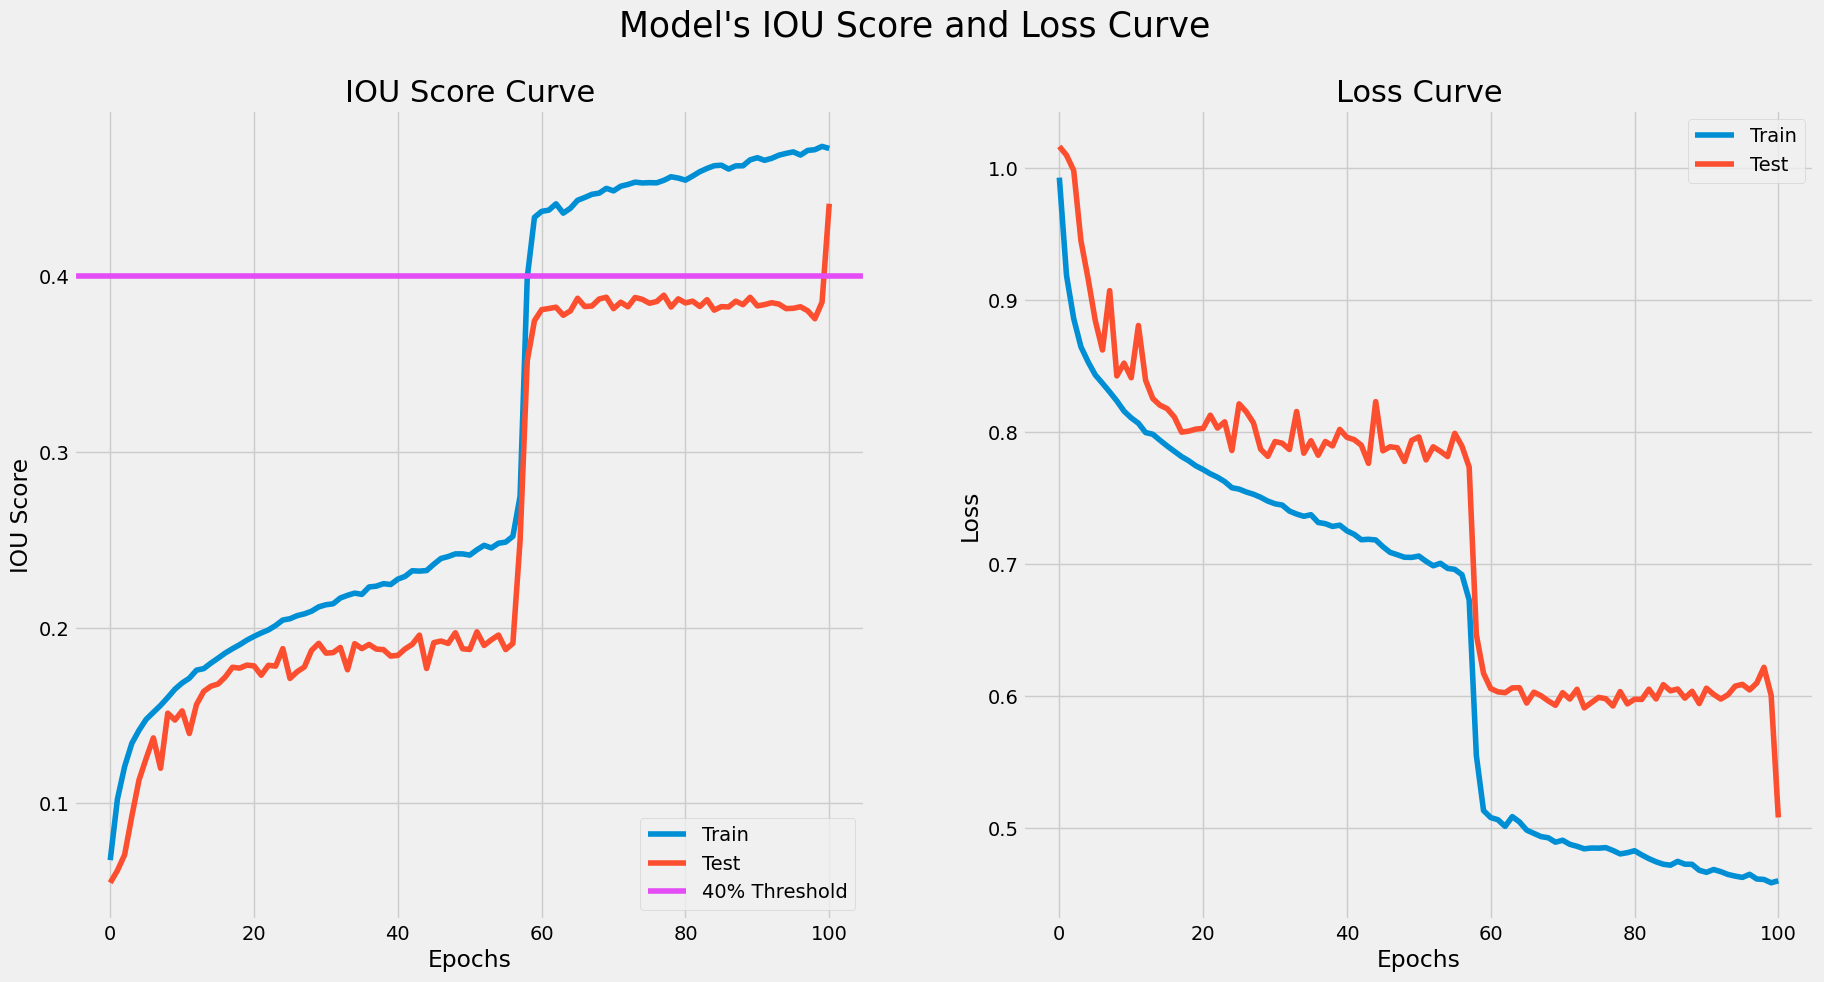

In [50]:
# Plot training & validation iou_score values

plt.figure(figsize=(20, 10))
plt.suptitle("Model's IOU Score and Loss Curve", size = 25)
plt.subplot(121)
plt.plot(combined['iou_score'], label = 'Train')
plt.plot(combined['val_iou_score'], label = 'Test')
plt.axhline(0.4, color = '#E44CF6', label = '40% Threshold')
plt.title('IOU Score Curve', size = 22)
plt.ylabel('IOU Score')
plt.xlabel('Epochs')
plt.legend(loc = 4)

# Plot training & validation loss values
plt.subplot(122)
plt.plot(combined['loss'], label = 'Train')
plt.plot(combined['val_loss'], label = 'Test')
plt.title('Loss Curve', size = 22)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc = 1)

plt.show()

1/1 [==============================] - 1s 1s/step


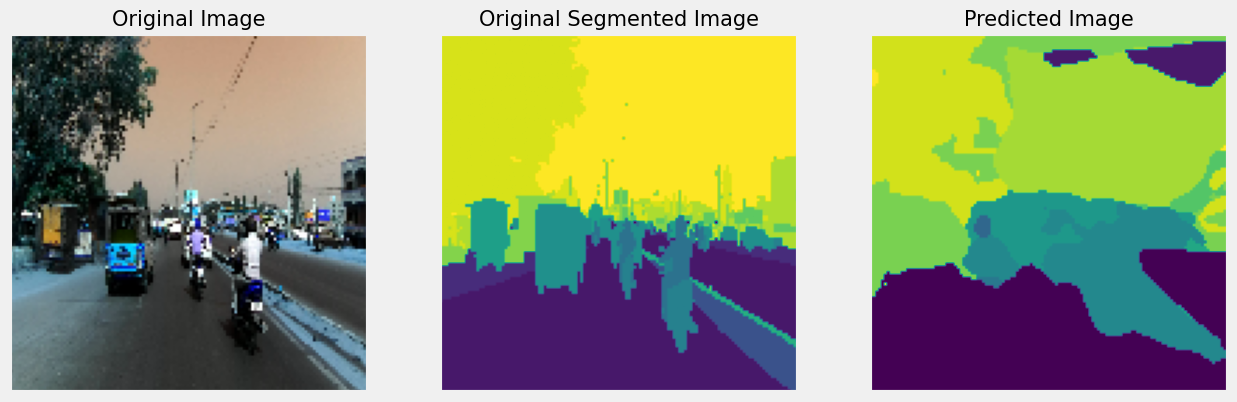

1/1 [==============================] - 0s 36ms/step


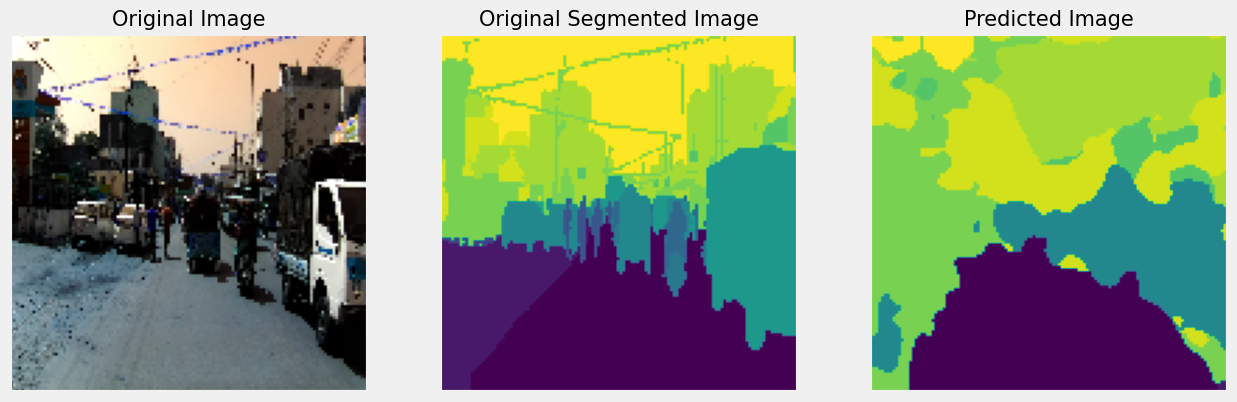

1/1 [==============================] - 0s 37ms/step


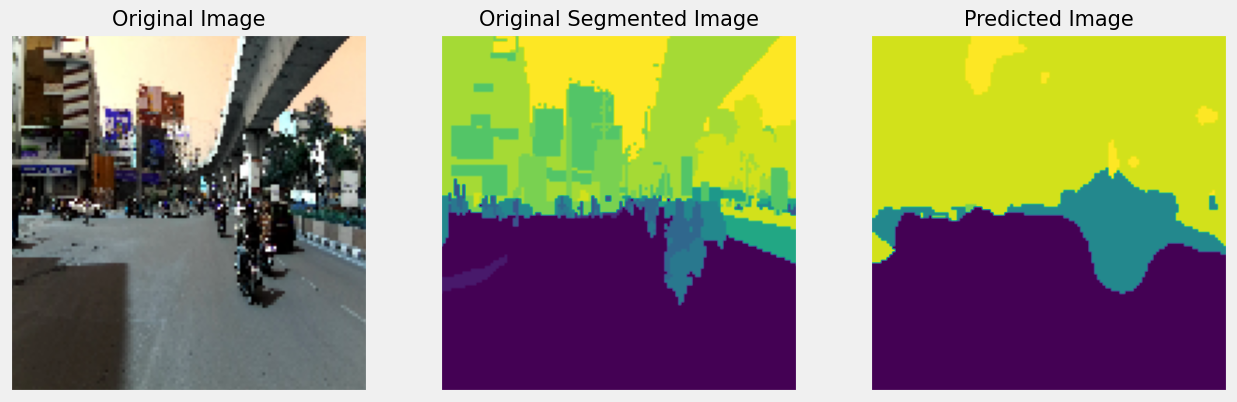

1/1 [==============================] - 0s 36ms/step


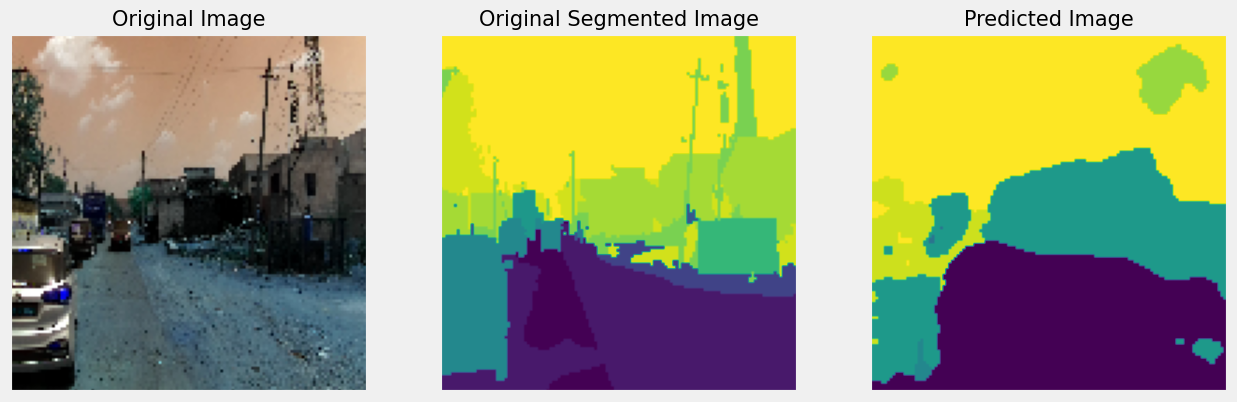

1/1 [==============================] - 0s 35ms/step


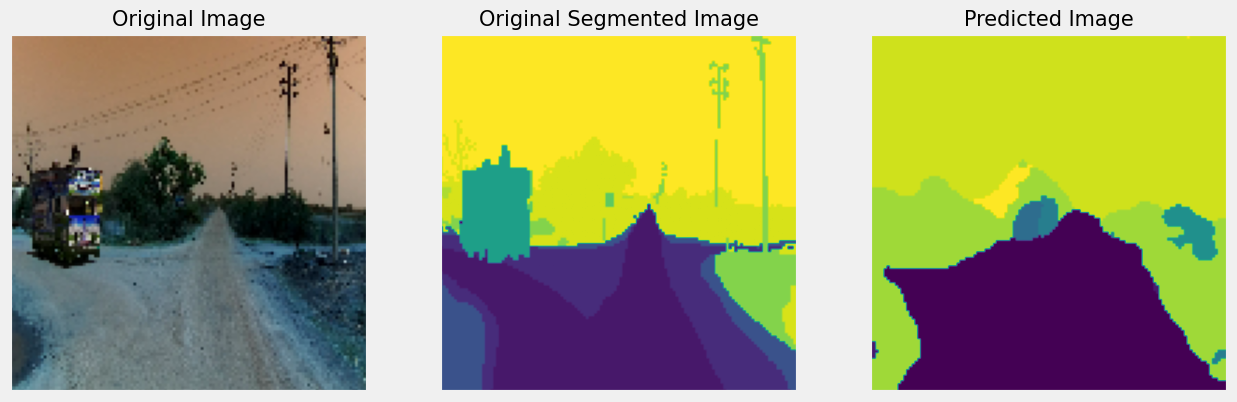

1/1 [==============================] - 0s 34ms/step


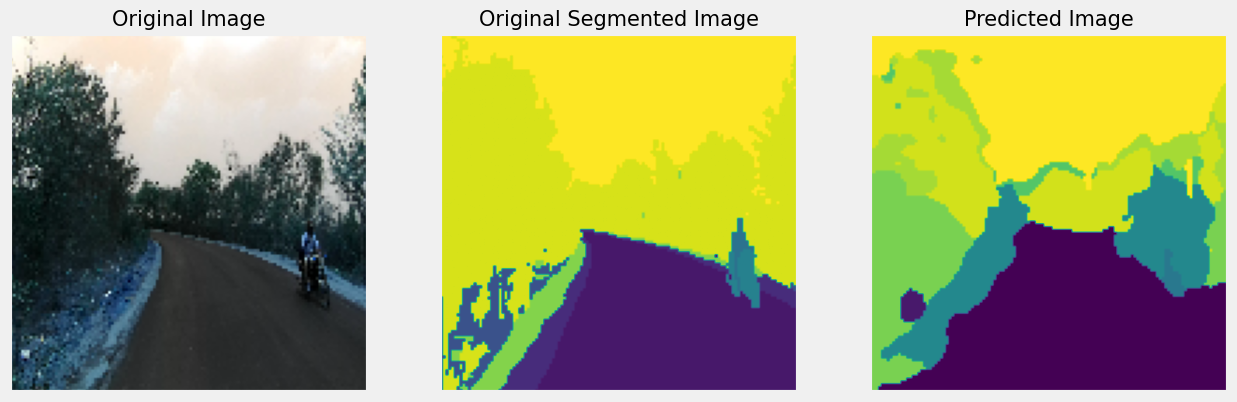

1/1 [==============================] - 0s 38ms/step


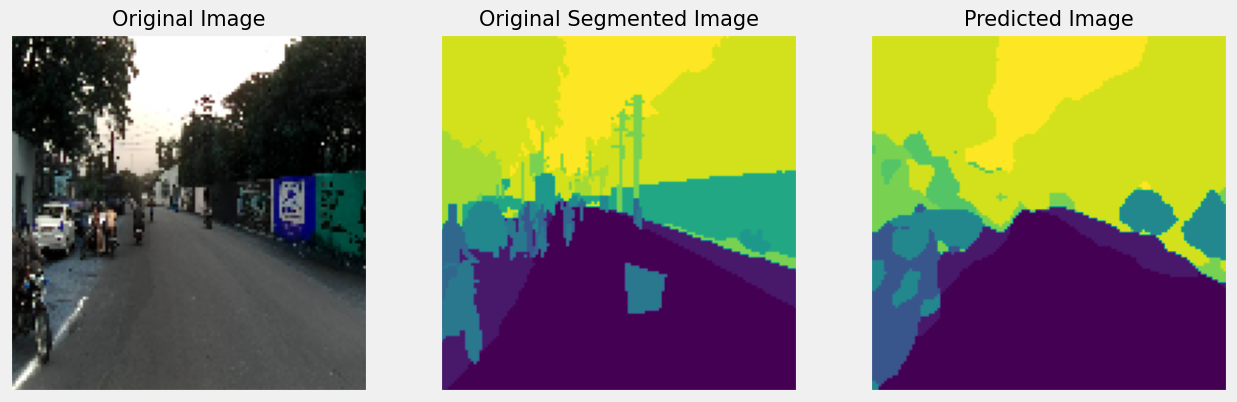

1/1 [==============================] - 0s 34ms/step


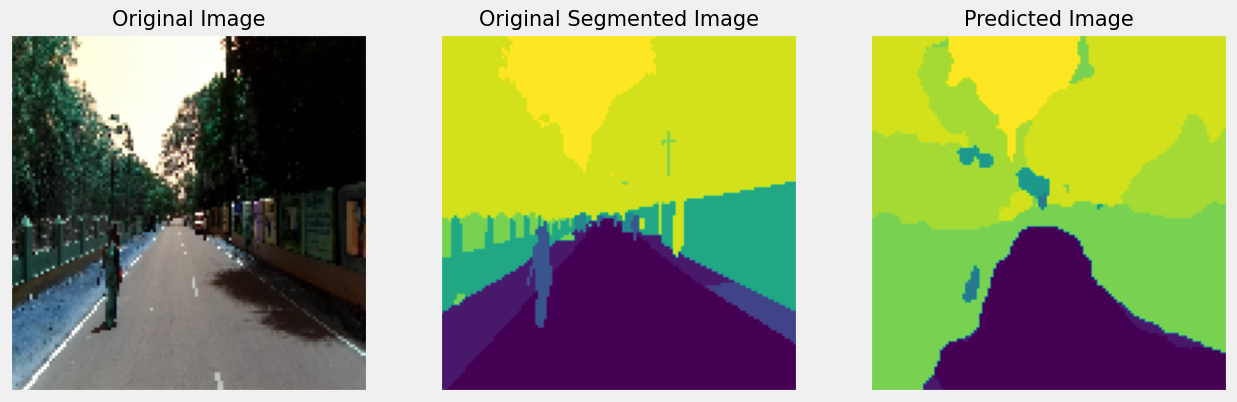

1/1 [==============================] - 0s 34ms/step


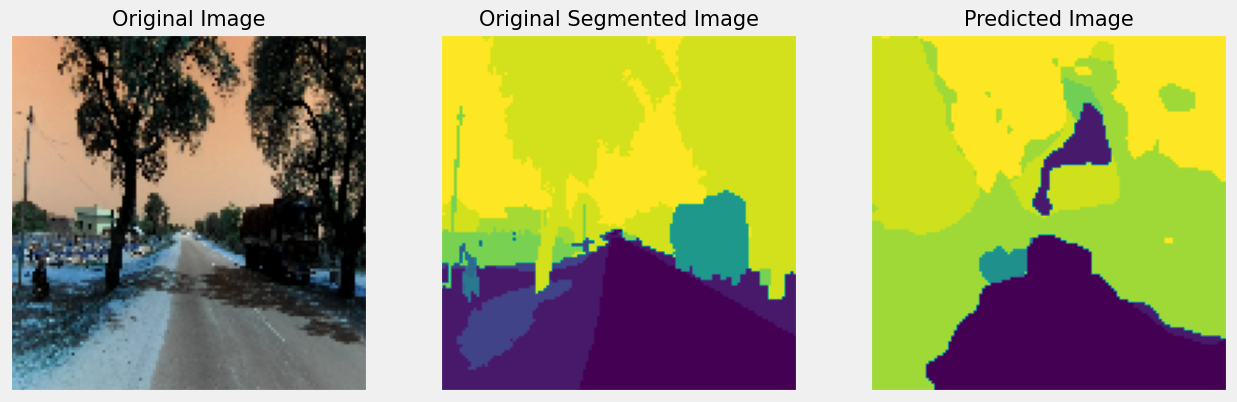

1/1 [==============================] - 0s 36ms/step


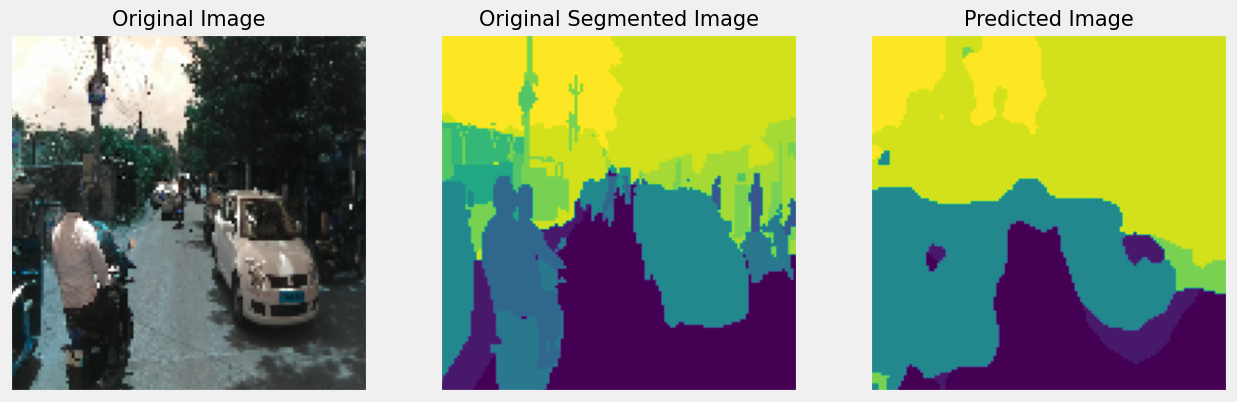

1/1 [==============================] - 0s 37ms/step


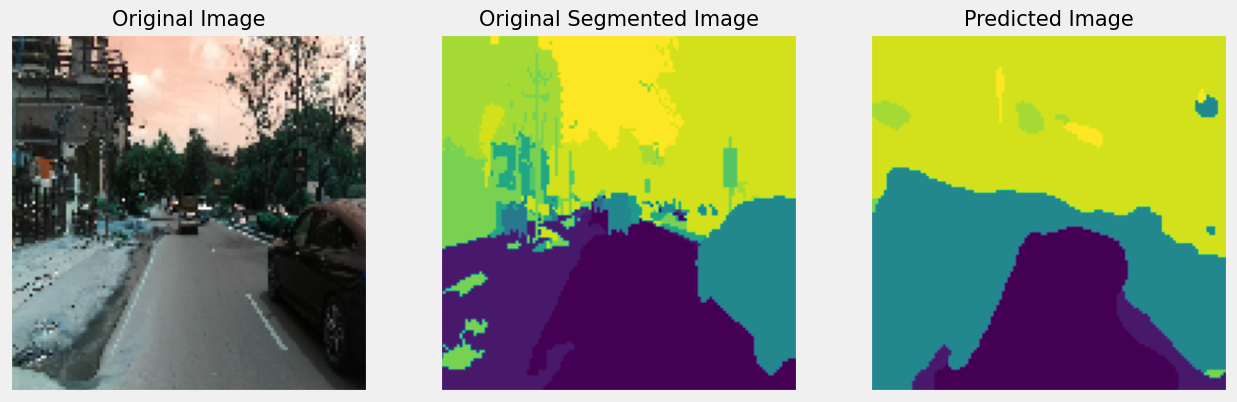

1/1 [==============================] - 0s 35ms/step


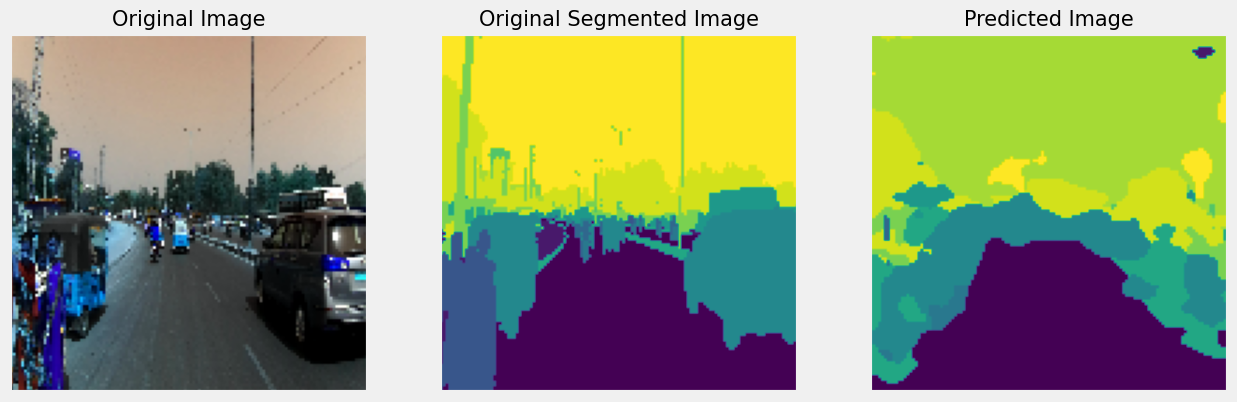

1/1 [==============================] - 0s 34ms/step


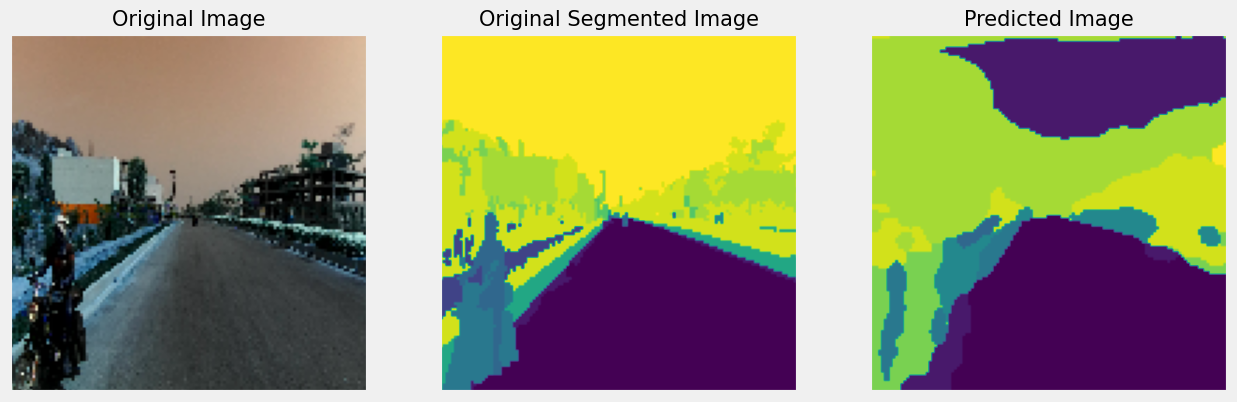

1/1 [==============================] - 0s 29ms/step


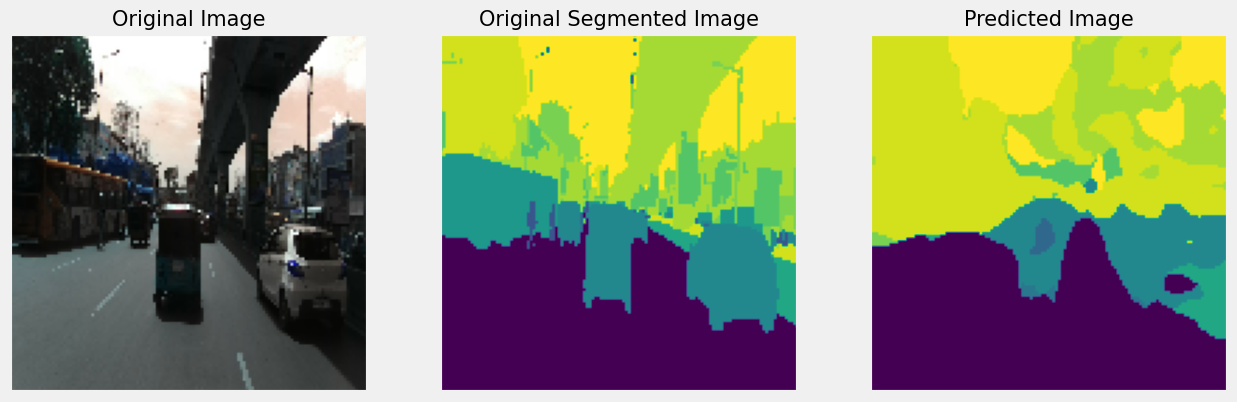

1/1 [==============================] - 0s 31ms/step


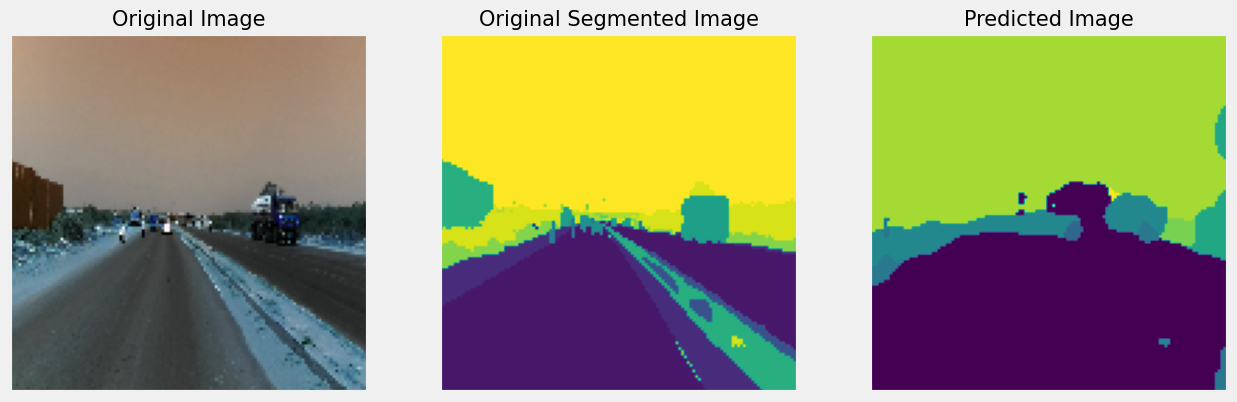

1/1 [==============================] - 0s 32ms/step


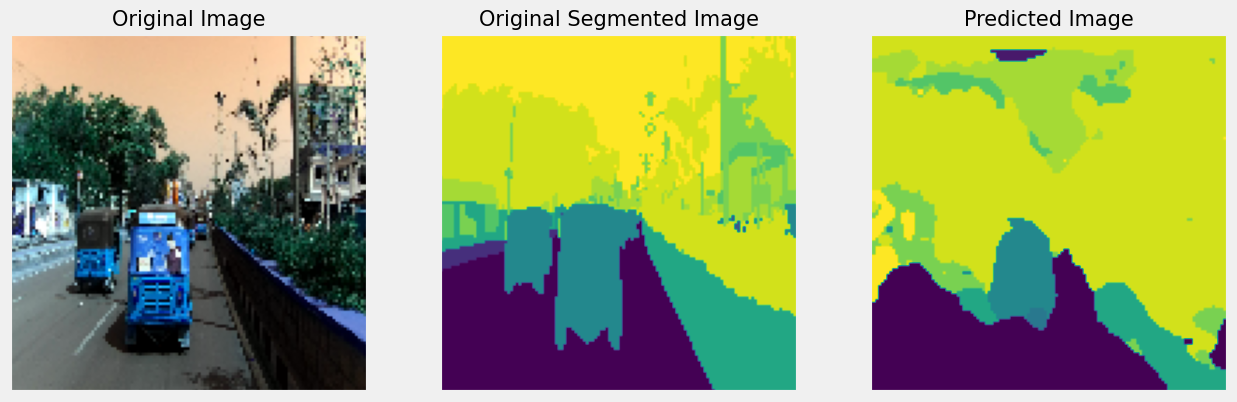

1/1 [==============================] - 0s 24ms/step


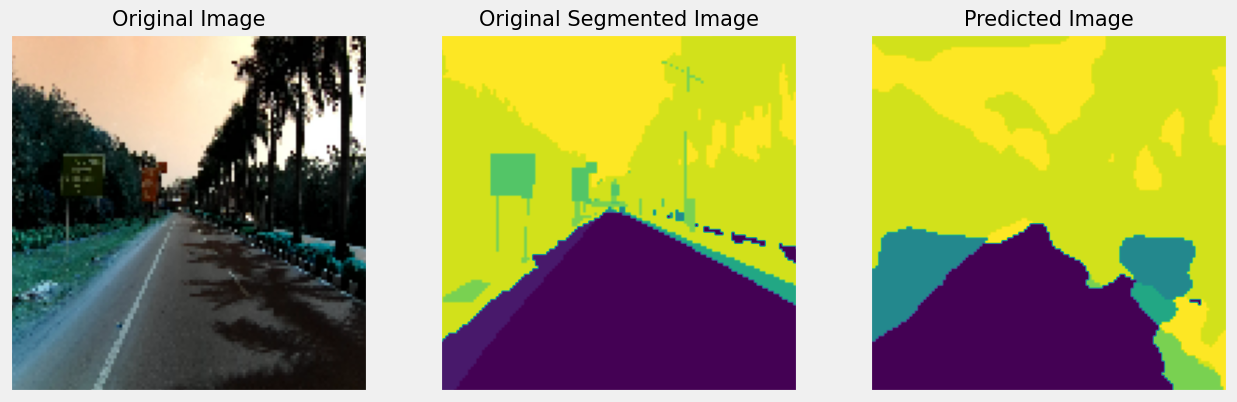

1/1 [==============================] - 0s 26ms/step


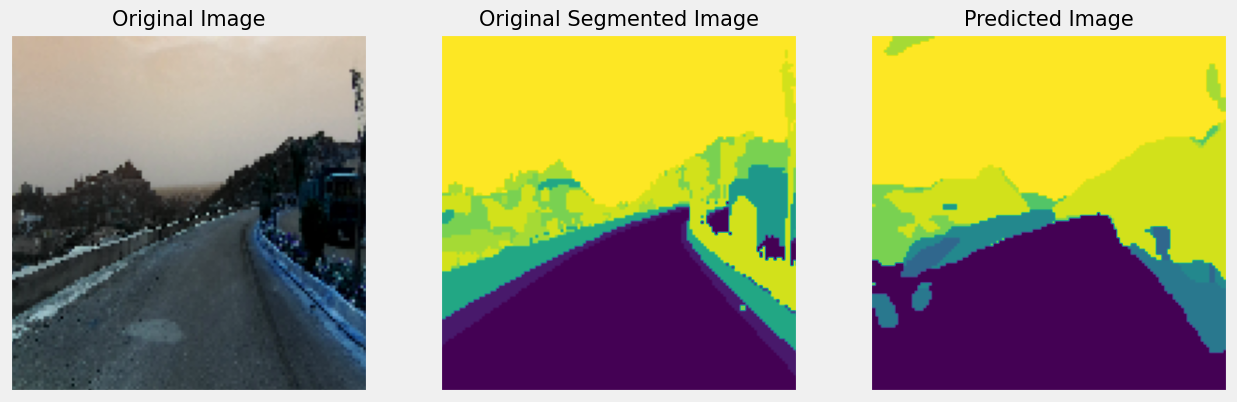

1/1 [==============================] - 0s 24ms/step


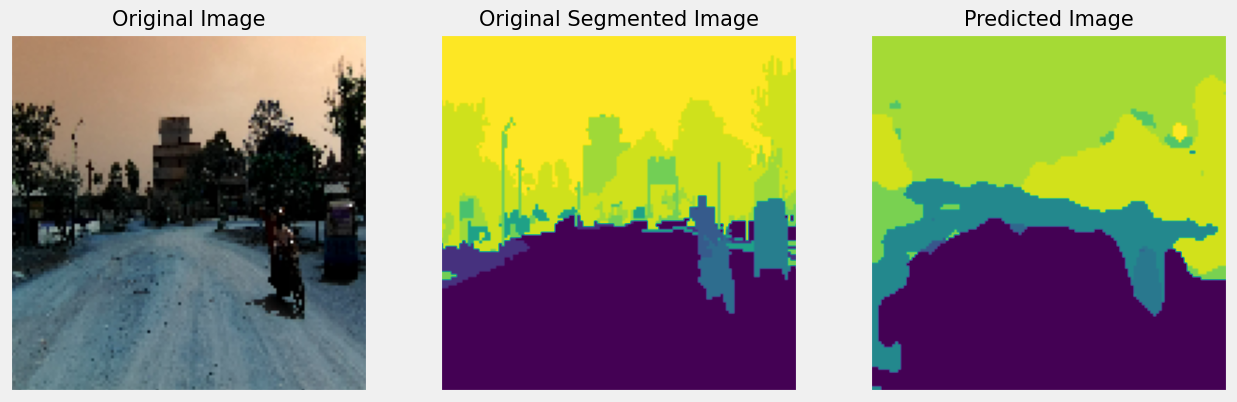

1/1 [==============================] - 0s 29ms/step


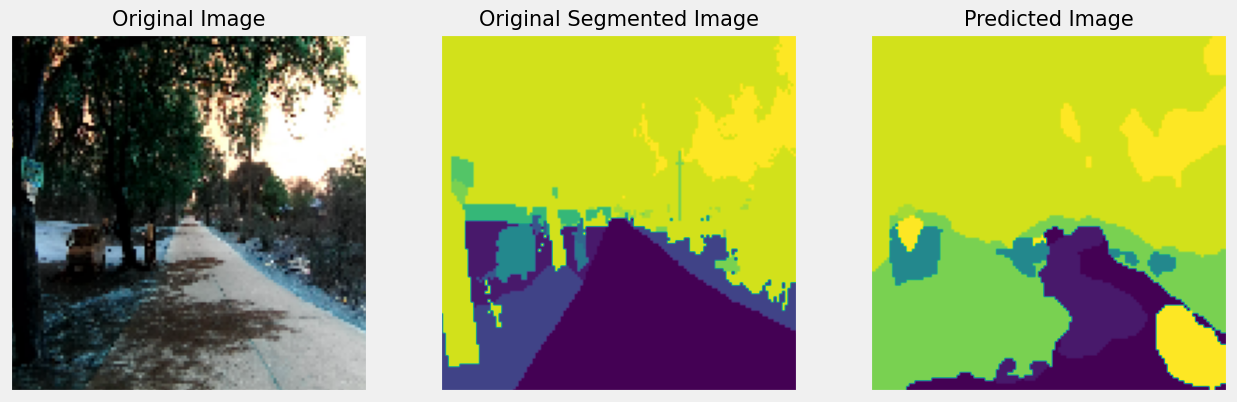

In [51]:
random_img_idx = np.random.choice(np.arange(X_test.shape[0]), size = 20, replace = False)

for idx in random_img_idx:

    # Reading original image
    image_ = cv2.imread(X_test.iloc[idx]['image'], cv2.IMREAD_UNCHANGED)
    image_ = cv2.resize(image_, (IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_NEAREST)

    # Reading segmented image
    image_mask_ = cv2.imread(X_test.iloc[idx]['mask'], cv2.IMREAD_UNCHANGED)
    image_mask_ = cv2.resize(image_mask_, (IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_NEAREST)

    # Generating predicted image
    pred_mask_ = model_canet.predict(image_[np.newaxis,:,:,:])
    pred_mask_ = tf.argmax(pred_mask_, axis = -1)

    plt.rcParams['axes.grid'] = False
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['ytick.labelleft'] = False

    plt.figure(figsize = (14,5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(image_)
    plt.subplot(132)
    plt.title('Original Segmented Image')
    plt.imshow(image_mask_)
    plt.subplot(133)
    plt.title('Predicted Image')
    plt.imshow(pred_mask_[0])
    plt.show()

In [52]:
!ls results/

canet		    model_canet3.txt  model_canet.h5	     wt_model_canet4.h5
combined_canet.txt  model_canet4.h5   model_CANet.png	     wt_model_canet5.h5
label_clr.pkl	    model_canet4.txt  model_canet.txt	     wt_model_canet6.h5
logs		    model_canet5.h5   preprocessed_data.csv  wt_model_canet.h5
model_canet2.h5     model_canet5.txt  unet
model_canet2.txt    model_canet6.h5   wt_model_canet2.h5
model_canet3.h5     model_canet6.txt  wt_model_canet3.h5


In [53]:
!zip -r CANet_F_101Epo_loss_4604_iou_4729_vloss_5084_viou_4414.zip results/

  adding: results/ (stored 0%)
  adding: results/model_canet4.txt (deflated 53%)
  adding: results/label_clr.pkl (deflated 35%)
  adding: results/model_canet2.h5 (deflated 26%)
  adding: results/model_canet5.txt (deflated 54%)
  adding: results/preprocessed_data.csv (deflated 93%)
  adding: results/wt_model_canet2.h5 (deflated 25%)
  adding: results/model_canet5.h5 (deflated 26%)
  adding: results/wt_model_canet6.h5 (deflated 25%)
  adding: results/unet/ (stored 0%)
  adding: results/wt_model_canet.h5 (deflated 25%)
  adding: results/model_canet3.txt (deflated 52%)
  adding: results/model_canet2.txt (deflated 53%)
  adding: results/wt_model_canet3.h5 (deflated 25%)
  adding: results/combined_canet.txt (deflated 54%)
  adding: results/wt_model_canet5.h5 (deflated 25%)
  adding: results/canet/ (stored 0%)
  adding: results/canet/EPO_01-IOU_0.055.h5 (deflated 26%)
  adding: results/model_canet3.h5 (deflated 26%)
  adding: results/model_canet.txt (deflated 52%)
  adding: results/model_CANe

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations